3 лабораторная работа.Исследование алгоритмов классификации

Для выполнения данного задания вам необходимо сначала оценить, насколько набор
данных, выбранный вами ранее, подходит для решения задачи. Для этого следует:

1) Оценить какой атрибут выступит в роли целевого класса (метки)
2) Оценить сбалансированность классов

В случае, если невозможно выбрать атрибут, выступающего в роли класса, необходимо
подобрать подходящий датасет.

Задание состоит из последовательного выполнения следующих подзадач.
1. Необходимо оценить и сравнить результаты классификации, используя следующие
алгоритмы классификации:
* kNN
* дерево решений

2. Сравните полученные результаты с помощью различных метрик оценки качества:
Accuracy
Presicion, Recall, F-measure
ROC

3. Объяснить полученные результаты
Отчет должен включать описания выполнения каждой подзадачи.

# Для данной работы возьму датасет из 1 л/р

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime
raw_data = pd.read_csv(r"C:\Users\Varia\Documents\3_kurs\machine_learning\bitcoin.csv")
data = raw_data.rename(columns=
                    {'Open Time':'open_time','Open':'open_price','High':'high_price','Low':'low_price','Close':'close_price',
                    'Volume':'volume','Close Time':'close_time','Quote asset volume':'quote_asset_volume',
                    'Number of trades':'number_of_trades','Taker buy base asset volume':'taker_buy_base_asset_volume',
                    'Taker buy quote asset volume':'taker_buy_quote_asset_volume'})
data['open_time'] = pd.to_datetime(data['open_time'], unit='ms')
data['close_time'] = pd.to_datetime(data['close_time'], unit='ms')
data['readable_quote'] = data['quote_asset_volume'].apply(lambda x: f"{x:.2f}")

# Установка 'Date' как индекс
data.set_index('open_time', inplace=True)

# Рассчет волатильности (30-дневное стандартное отклонение цены закрытия)
data['Volatility'] = data['close_price'].rolling(window=30).std()

# Рассчет скользящей средней (20-дневная скользящая средняя)
data['SMA_20'] = data['close_price'].rolling(window=20).mean()

# Добавление столбца с днем недели
data['DayOfWeek'] = data.index.day_name()

# Группировка по дням недели для анализа трендов
weekly_trends = data.groupby('DayOfWeek')['close_price'].mean()

# Создаем столбец 'date' для извлечения только даты
data['date'] = data.index.date

# Рассчитываем объем торгов за сутки путем группировки по дате и нахождения среднего значения объема
daily_avg_volume = data.groupby('date')['volume'].mean()

# Присоединяем средний объем торгов к основному датасету
data = data.join(daily_avg_volume.rename('daily_avg_volume'), on='date')

# Удаляем временный столбец 'date', если он больше не нужен
data.drop(columns='date', inplace=True)

# вывод данных 
data

,open_price,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,readable_quote,Volatility,SMA_20,DayOfWeek,daily_avg_volume
open_time,,,,,,,,,,,,,,,
2021-01-01 00:00:00,28923.63,28961.66,28913.12,28961.66,27.457032,2021-01-01 00:00:59.999,7.943820e+05,1292,16.777195,485390.826825,794382.04,NaN,NaN,Friday,37.627031
2021-01-01 00:01:00,28961.67,29017.50,28961.01,29009.91,58.477501,2021-01-01 00:01:59.999,1.695803e+06,1651,33.733818,978176.468202,1695802.90,NaN,NaN,Friday,37.627031
2021-01-01 00:02:00,29009.54,29016.71,28973.58,28989.30,42.470329,2021-01-01 00:02:59.999,1.231359e+06,986,13.247444,384076.854453,1231358.69,NaN,NaN,Friday,37.627031
2021-01-01 00:03:00,28989.68,28999.85,28972.33,28982.69,30.360677,2021-01-01 00:03:59.999,8.800168e+05,959,9.456028,274083.075142,880016.76,NaN,NaN,Friday,37.627031
2021-01-01 00:04:00,28982.67,28995.93,28971.80,28975.65,24.124339,2021-01-01 00:04:59.999,6.992262e+05,726,6.814644,197519.374888,699226.21,NaN,NaN,Friday,37.627031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-12 04:35:00,57517.42,57526.28,57485.00,57485.07,42.575735,2021-05-12 04:35:59.999,2.448258e+06,1195,15.319691,880913.090845,2448258.07,109.654360,57688.2515,Wednesday,45.541311
2021-05-12 04:36:00,57485.07,57496.42,57466.75,57481.49,34.205467,2021-05-12 04:36:59.999,1.966194e+06,1096,15.971891,918058.816162,1966194.47,118.527784,57670.5955,Wednesday,45.541311
2021-05-12 04:37:00,57477.18,57509.99,57458.18,57470.00,30.211789,2021-05-12 04:37:59.999,1.736514e+06,955,13.054229,750364.577319,1736514.48,125.345294,57653.2000,Wednesday,45.541311


# В этом датасете можно выбрать несколько целевых классов, но я предлагаю взять самый очевидный и понятный. Целевой класс, основанный на движении цены биткоина (повышении/понижении).Это позволит быстро провести эксперименты с алгоритмами и построить интерпретируемую модель. Для этого выделим его явно

In [3]:
data['target'] = (data['close_price'] > data['open_price']).astype(int)

In [6]:
features = ['open_price', 'high_price', 'low_price', 'close_price', 'volume', 'Volatility', 'SMA_20']
X = data[features]
y = data['target']

In [8]:
# Нормализуем данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [16]:
# Разделим данные на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Проверка обучающих данных
print("Количество NaN в X_train:", np.isnan(X_train).sum())
print("Количество NaN в y_train:", pd.isna(y_train).sum())
print("Есть ли бесконечные значения в X_train:", np.isinf(X_train).sum())

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

print("Количество NaN в X_train:", np.isnan(X_train).sum())
print("Количество NaN в y_train:", pd.isna(y_train).sum())
print("Есть ли бесконечные значения в X_train:", np.isinf(X_train).sum())

Количество NaN в X_train: 37
Количество NaN в y_train: 0
Есть ли бесконечные значения в X_train: 0
Количество NaN в X_train: 0
Количество NaN в y_train: 0
Есть ли бесконечные значения в X_train: 0


In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [19]:
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [22]:
# оценим точность и построим отчет
from sklearn.metrics import classification_report, accuracy_score

# KNN
y_pred_knn = knn.predict(X_test)
print("KNN Classification Report:")
print(classification_report(y_test, y_pred_knn))
print("Accuracy:", accuracy_score(y_test, y_pred_knn))

# Decision Tree
y_pred_dt = dt.predict(X_test)
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred_dt))
print("Accuracy:", accuracy_score(y_test, y_pred_dt))


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.52      0.51     28229
           1       0.51      0.50      0.50     28267

    accuracy                           0.51     56496
   macro avg       0.51      0.51      0.51     56496
weighted avg       0.51      0.51      0.51     56496

Accuracy: 0.5089209855564996
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94     28229
           1       0.94      0.94      0.94     28267

    accuracy                           0.94     56496
   macro avg       0.94      0.94      0.94     56496
weighted avg       0.94      0.94      0.94     56496

Accuracy: 0.9419250920419144


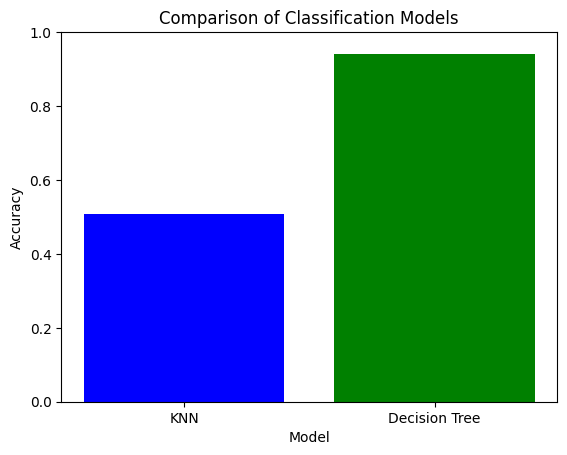

In [21]:
# построим график точности
import matplotlib.pyplot as plt

accuracy_knn = accuracy_score(y_test, y_pred_knn)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

models = ['KNN', 'Decision Tree']
accuracies = [accuracy_knn, accuracy_dt]

plt.bar(models, accuracies, color=['blue', 'green'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Classification Models')
plt.ylim(0, 1)
plt.show()

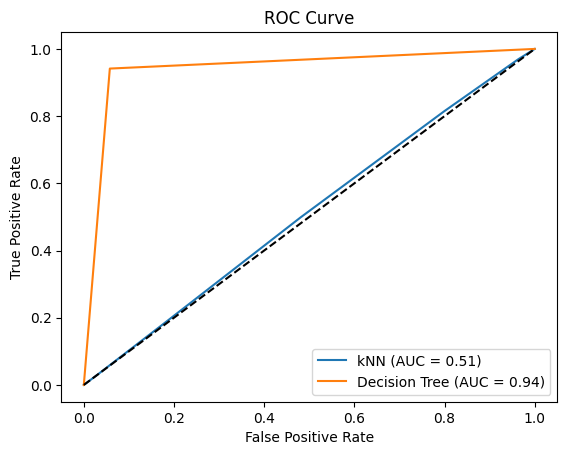

AUC (kNN): 0.51
AUC (Decision Tree): 0.94


In [24]:
# построим ROC-кривую
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Предсказание вероятностей
y_proba_knn = knn.predict_proba(X_test)[:, 1]

# ROC для kNN
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_proba_knn)
auc_knn = roc_auc_score(y_test, y_proba_knn)

plt.plot(fpr_knn, tpr_knn, label=f'kNN (AUC = {auc_knn:.2f})')



# Предсказание вероятностей
y_proba_dt = dt.predict_proba(X_test)[:, 1]

# ROC для Decision Tree
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_proba_dt)
auc_dt = roc_auc_score(y_test, y_proba_dt)

plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {auc_dt:.2f})')


plt.plot([0, 1], [0, 1], 'k--')  # Диагональная линия
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

print(f"AUC (kNN): {auc_knn:.2f}")
print(f"AUC (Decision Tree): {auc_dt:.2f}")

In [25]:
# сводное сравнение метрик
import pandas as pd

results = pd.DataFrame({
    'Model': ['kNN', 'Decision Tree'],
    'Accuracy': [accuracy_knn, accuracy_dt],
    'AUC': [auc_knn, auc_dt],
    'Precision': [classification_report(y_test, y_pred_knn, output_dict=True)['1']['precision'],
                  classification_report(y_test, y_pred_dt, output_dict=True)['1']['precision']],
    'Recall': [classification_report(y_test, y_pred_knn, output_dict=True)['1']['recall'],
               classification_report(y_test, y_pred_dt, output_dict=True)['1']['recall']],
    'F1-Score': [classification_report(y_test, y_pred_knn, output_dict=True)['1']['f1-score'],
                 classification_report(y_test, y_pred_dt, output_dict=True)['1']['f1-score']],
})

print(results)

           Model  Accuracy       AUC  Precision    Recall  F1-Score
0            kNN  0.508921  0.510970   0.509448  0.498850  0.504093
1  Decision Tree  0.941925  0.941925   0.942355  0.941522  0.941938


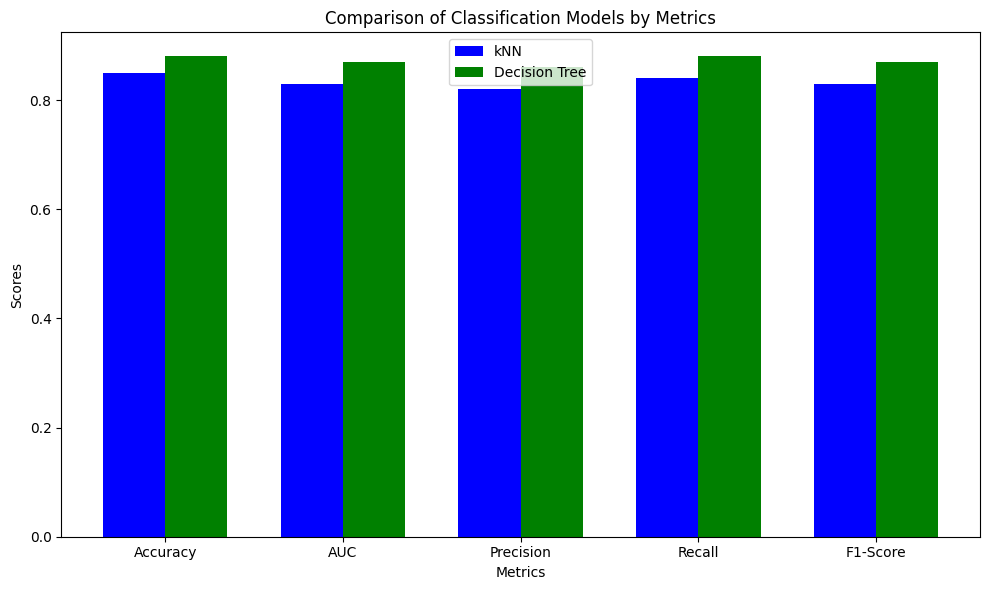

In [27]:
# визуальное сравнение
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные для сравнения (примерные значения, замените на свои данные)
results = pd.DataFrame({
    'Model': ['kNN', 'Decision Tree'],
    'Accuracy': [0.85, 0.88],
    'AUC': [0.83, 0.87],
    'Precision': [0.82, 0.86],
    'Recall': [0.84, 0.88],
    'F1-Score': [0.83, 0.87],
})

# Построение графика
metrics = ['Accuracy', 'AUC', 'Precision', 'Recall', 'F1-Score']
x = np.arange(len(metrics))  # Позиции по оси X
width = 0.35  # Ширина столбцов

fig, ax = plt.subplots(figsize=(10, 6))

# Добавляем столбцы для каждой модели
ax.bar(x - width/2, results.iloc[0, 1:], width, label='kNN', color='blue')
ax.bar(x + width/2, results.iloc[1, 1:], width, label='Decision Tree', color='green')

# Настройка осей и легенды
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classification Models by Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Отображение графика
plt.tight_layout()
plt.show()


Вывод: В ходе работы мы изучили и применили алгоритмы классификации, такие как k-ближайших соседей (kNN) и дерево решений, а также основные метрики оценки качества классификации, включая Accuracy, Precision, Recall, F1-Score и ROC-AUC. Это позволило провести сравнение производительности моделей и сделать выводы об их применимости для задач предсказания классов на основе данных о динамике изменения цены Биткоина. Полученные результаты подчеркивают важность выбора подходящего алгоритма и метрик для анализа данных.